In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
import utils
import indep_sites

import pickle
import glob
from math import ceil, sqrt, floor
import random
from pathlib import Path 

/home/scrotti/Aptamer2025py/experiments/../indep_sites.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [5]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = range(len(round_ids))

In [6]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [7]:
ps_small = np.logspace(-8,-1.5,10)
ps_large = 1 - ps_small
ps_spaced = np.linspace(0, 0.95, 20)
pseudocounts = np.concatenate((ps_small, ps_large, ps_spaced))
pseudocounts = np.round(pseudocounts, decimals=8)
pseudocounts.sort()
pseudocounts

array([0.0000000e+00, 1.0000000e-08, 5.0000000e-08, 2.8000000e-07,
       1.4700000e-06, 7.7400000e-06, 4.0840000e-05, 2.1544000e-04,
       1.1364600e-03, 5.9948400e-03, 3.1622780e-02, 5.0000000e-02,
       1.0000000e-01, 1.5000000e-01, 2.0000000e-01, 2.5000000e-01,
       3.0000000e-01, 3.5000000e-01, 4.0000000e-01, 4.5000000e-01,
       5.0000000e-01, 5.5000000e-01, 6.0000000e-01, 6.5000000e-01,
       7.0000000e-01, 7.5000000e-01, 8.0000000e-01, 8.5000000e-01,
       9.0000000e-01, 9.5000000e-01, 9.6837722e-01, 9.9400516e-01,
       9.9886354e-01, 9.9978456e-01, 9.9995916e-01, 9.9999226e-01,
       9.9999853e-01, 9.9999972e-01, 9.9999995e-01, 9.9999999e-01])

Read frequencies

In [8]:
data = []
for n in ns:  
    data_n = []
    experiment_id = experiment_ids[n]
    for pseudocount in pseudocounts:    
        pc_str = format(pseudocount, '.8f')
        
        filename = experiment_id + "freq_pseudocount" + pc_str + ".pkl"
        filepath = "saved/freq_pseudocount/" + filename
        
        with open(filepath, 'rb') as f:
            # fi, fij, total_reads = pickle.load(f) 
            data_n.append(pickle.load(f))
    data.append(zip(*data_n))
    
fi_all, fij_all, total_reads_all = zip(*(data))

Read parameters

In [9]:
data = []

for n in ns:
    data.append([])
    dir = './saved/pseudocount/indep_sites/'
    for filepath in sorted(glob.iglob(dir + experiment_ids[n]+'*.pkl')):
        with open(filepath, 'rb') as f:
            data[-1].append(pickle.load(f))
    print(f"Dataset f{experiment_ids[n]}. Loaded {len(data[-1])} files.")

experiment_id_all, round_ids_all, params_all, pseudocount_all = zip(*[
    zip(*d) for d in data])

for n in ns:
    assert((sorted(np.array(pseudocount_all[n])) == np.array(pseudocount_all[n])).all())
    assert((np.array(experiment_id_all[n]) == experiment_ids[n]).all())

Dataset fDop8V030. Loaded 40 files.
Dataset fDop8V930. Loaded 40 files.
Dataset fDop8V2430. Loaded 40 files.


In [10]:
pc_idx = range(len(pseudocount_all[0]))

In [11]:
params_zerosum_all = [[utils.set_zerosum_gauge(params_all[n][a])
                        for a in pc_idx] for n in ns]
params_all = params_zerosum_all

In [19]:
def _get_slope(x, y):
    x = x.view(-1)
    y = y.view(-1)
    n = len(x)
    num = n * (x @ y) - y.sum() * x.sum()
    den = n * (x @ x) - torch.square(x.sum())
    return num / den

def _get_pearson(x, y):
    x = x.view(-1)
    y = y.view(-1)
    return torch.corrcoef(torch.stack((x,y)))[0,1].item()

In [59]:
def compute_stuff(n, a):
    total_reads = total_reads_all[n][0]
    T = len(ts)
    A = total_reads.sum().item()
    B = (torch.arange(T) * total_reads).sum().item()
    C = (torch.square(torch.arange(T)) * total_reads).sum().item()
    fi = fi_all[n][0]
    Riat = total_reads[:,None,None] * fi
    Aia = Riat.sum(0)
    T = len(ts)
    Bia = (torch.arange(T)[:,None,None] * Riat).sum(0)
    q = Riat.size(-1)
    dhdalpha =   q * (B*Aia - A*Bia) / (B**2 - A*C)
    # dkdalpha = - q * (C*Aia - B*Bia - A + B**2/C) / (B**2 - A*C)
    dkdalpha = 1 - q * (Aia*C - B*Bia) / (B**2 - A*C)
    h = params_all[n][a]['bias_ps']
    k = params_all[n][a]['bias_Ns0']

    return h, k, dhdalpha, dkdalpha

In [65]:
n = 0
a = 30
dkdalpha = dkdalphas[a]
dkdalpha.sum(1)

tensor([8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
        8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
        8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
        8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000,
        8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000])

In [60]:
hs = []
ks = []
dhdalphas = []
dkdalphas = []

n = 0

for a in pc_idx:
    h, k, dhdalpha, dkdalpha = compute_stuff(n, a)
    hs.append(h); ks.append(k)
    dhdalphas.append(dhdalpha); dkdalphas.append(dkdalpha)

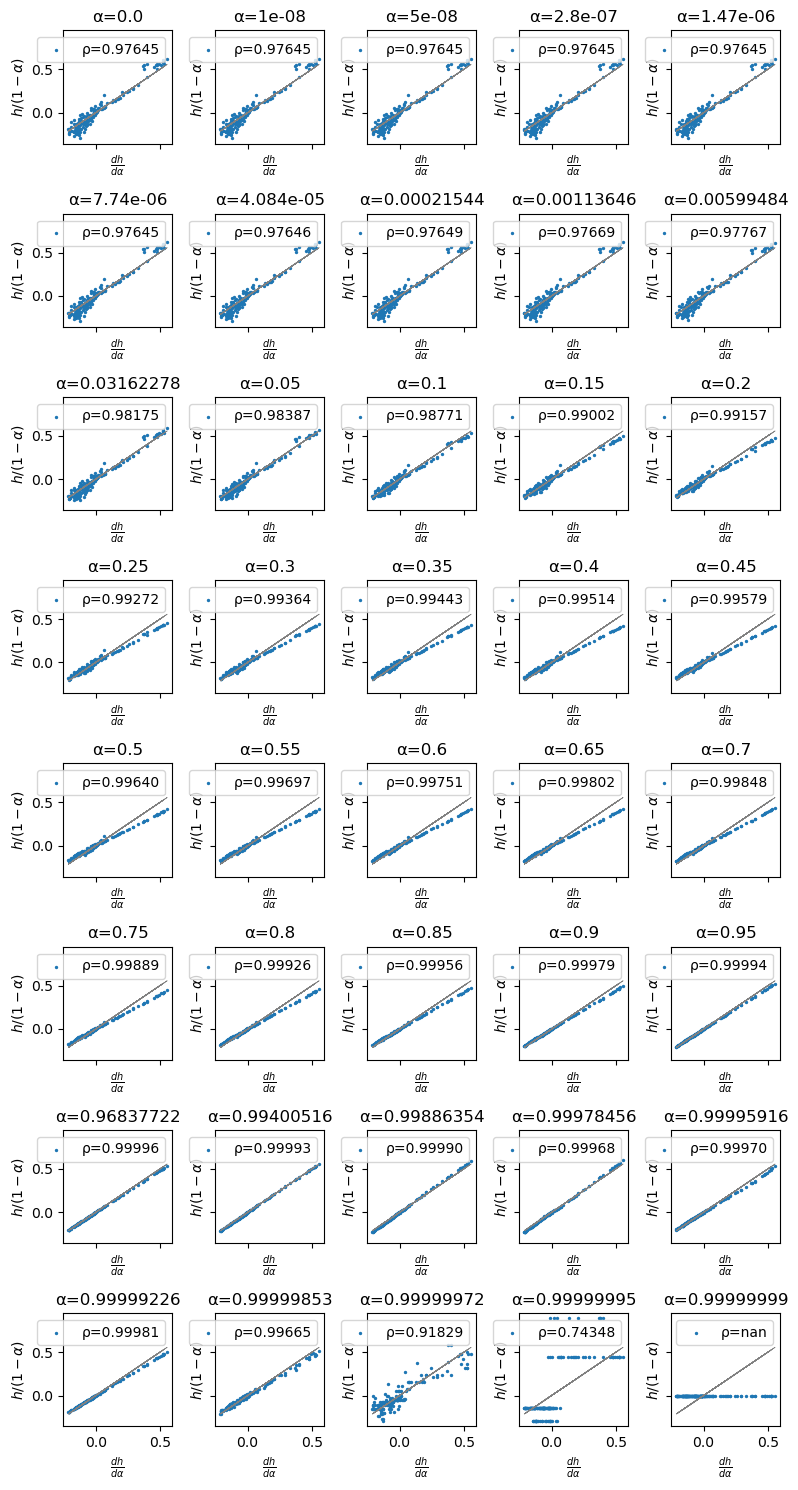

In [62]:
fig, axes = plt.subplots(8,5, figsize=(8,15), sharex=True, sharey=True)

a = -1
for b in range(8):
    for c in range(5):
        a += 1
        alpha = pseudocounts[a]
        ax = axes[b,c]
        x = dhdalphas[a]
        y = hs[a]/(1-alpha)
        rho = _get_pearson(x,y)
        ax.scatter(x, y, s=2, label=f"ρ={rho:.5f}")
        ax.legend()
        ax.plot(dhdalphas[a], dhdalphas[a], c="gray", linewidth=0.5)
        ax.set_title(f"α={alpha}")
        ax.set_xlabel(r'$\frac{dh}{d\alpha}$')
        ax.set_ylabel(r'$h/(1-\alpha)$')
plt.tight_layout()
plt.savefig('img/h_large_pseudocount_indep_sites.png')

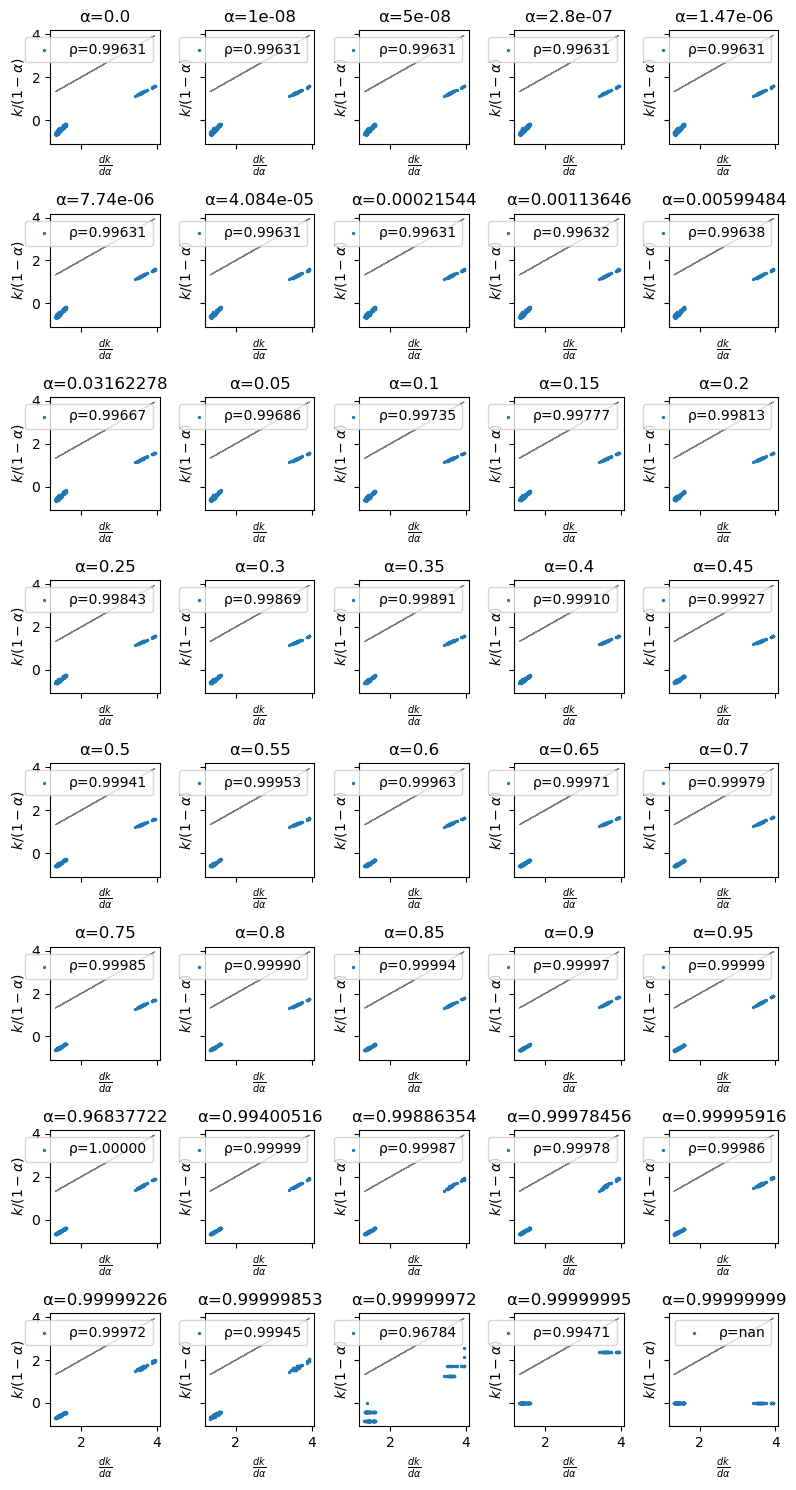

In [61]:
fig, axes = plt.subplots(8,5, figsize=(8,15), sharex=True, sharey=True)

a = -1
for b in range(8):
    for c in range(5):
        a += 1
        alpha = pseudocounts[a]
        ax = axes[b,c]
        x = dkdalphas[a]
        # x = x - x.mean(dim=1, keepdim=True)
        y = ks[a]/(1-alpha)
        # y = y - y.mean(dim=1, keepdim=True)
        rho = _get_pearson(x,y)
        ax.scatter(x, y, s=2, label=f"ρ={rho:.5f}")
        ax.plot(dkdalphas[a], dkdalphas[a], c="gray", linewidth=0.5)
        ax.legend()
        ax.set_title(f"α={alpha}")
        ax.set_xlabel(r'$\frac{dk}{d\alpha}$')
        ax.set_ylabel(r'$k/(1-\alpha)$')
plt.tight_layout()
plt.savefig('img/k_large_pseudocount_indep_sites.png')

In [15]:
slopes_k = [_get_slope(k/(1-alpha), dkdalpha)
            for (k, dkdalpha, alpha) in zip(ks, dkdalphas, pseudocounts)]
slopes_h = [_get_slope(k/(1-alpha), dkdalpha)
            for (k, dkdalpha, alpha) in zip(hs, dhdalphas, pseudocounts)]
pearsons_k = [_get_pearson(k/(1-alpha), dkdalpha)
            for (k, dkdalpha, alpha) in zip(ks, dkdalphas, pseudocounts)]
pearsons_h = [_get_pearson(k/(1-alpha), dkdalpha)
            for (k, dkdalpha, alpha) in zip(hs, dhdalphas, pseudocounts)]

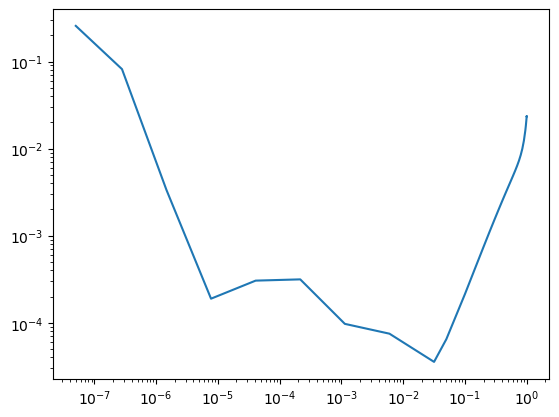

In [16]:
plt.plot(1-pseudocounts, [1-p for p in pearsons_h])
plt.xscale('log'); plt.yscale('log')

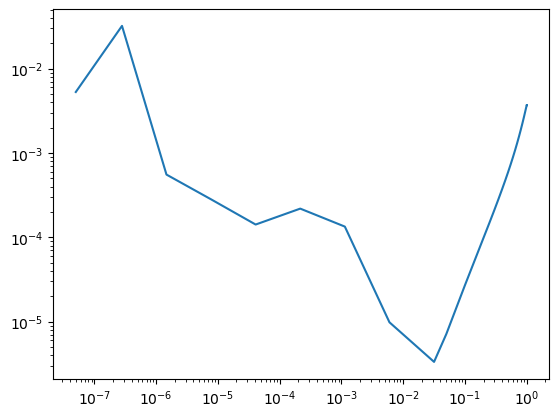

In [17]:
plt.plot(1-pseudocounts, [1-p for p in pearsons_k])
plt.xscale('log'); plt.yscale('log')

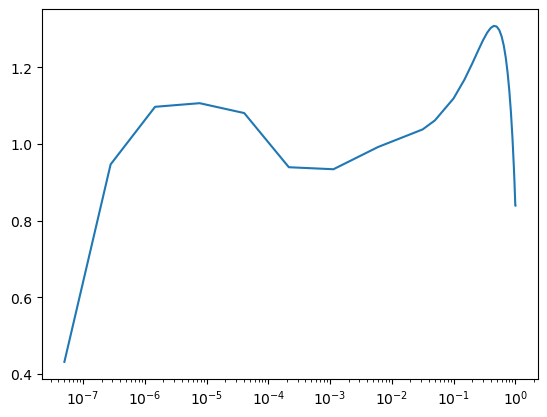

In [18]:
plt.plot(1-pseudocounts, slopes_h)
plt.xscale('log')
# plt.ylim((-5,5))

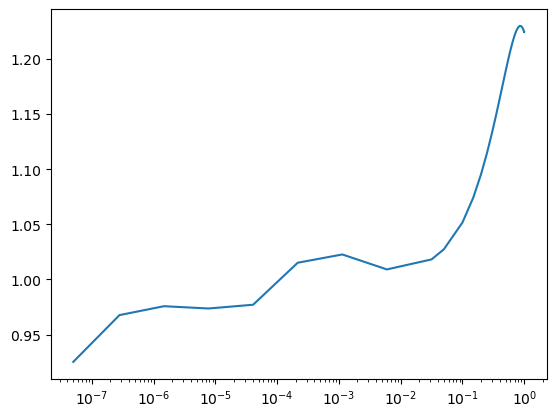

In [19]:
plt.plot(1-pseudocounts, slopes_k)
plt.xscale('log')

## With J

In [20]:
def build_pseudocount_system(fi, fij, total_reads, device='cpu'):
    """
    Build the linear system H @ x = g for computing parameter derivatives w.r.t. alpha.
    
    Parameters:
    -----------
    fi : torch.Tensor, shape (T, L, q)
        Empirical single-site frequencies at each round
        fi[t, i, a] = R_{i,t}^a / R_t (normalized frequencies)
    fij : torch.Tensor, shape (T, L, q, L, q)
        Empirical pair frequencies at each round
        fij[t, i, a, j, b] = R_{ij,t}^{ab} / R_t (normalized frequencies)
    total_reads : torch.Tensor, shape (T,)
        Total reads per round: R_t
    device : str
        Device for computation ('cpu' or 'cuda')
        
    Returns:
    --------
    H : torch.Tensor, shape (n_params, n_params)
        Hessian matrix
    g : torch.Tensor, shape (n_params,)
        Gradient vector (RHS)
    param_info : dict
        Information about parameter indexing
    """
    T, L, q = fi.shape
    
    # Move to device
    fi = fi.to(device)
    fij = fij.to(device)
    total_reads = total_reads.to(device)
    
    # Compute time-weighted sums
    t_indices = torch.arange(T, dtype=torch.float32, device=device)
    A = total_reads.sum()  # sum_t R_t
    B = (t_indices * total_reads).sum()  # sum_t t*R_t
    C = (t_indices**2 * total_reads).sum()  # sum_t t^2*R_t
    D = (t_indices**3 * total_reads).sum()  # sum_t t^3*R_t
    
    # Number of parameters (with gauge fixing: sum_a = 0 for each site)
    n_k = L * (q - 1)  # k parameters (fix last amino acid to 0)
    n_h = L * (q - 1)  # h parameters
    n_J = L * (L - 1) // 2 * (q - 1) * (q - 1)  # J parameters (i<j, fix last aa)
    n_params = n_k + n_h + n_J
    
    # Parameter indexing helpers
    def k_idx(i, a):
        """Index for k_i^a (a < q-1)"""
        return i * (q - 1) + a
    
    def h_idx(i, a):
        """Index for h_i^a (a < q-1)"""
        return n_k + i * (q - 1) + a
    
    def J_idx(i, j, a, b):
        """Index for J_{ij}^{ab} with i < j, a < q-1, b < q-1"""
        if i > j:
            i, j, a, b = j, i, b, a
        # Count pairs before (i,j)
        pair_idx = i * L - i * (i + 1) // 2 + (j - i - 1)
        return n_k + n_h + pair_idx * (q - 1) * (q - 1) + a * (q - 1) + b
    
    # Initialize matrices
    H = torch.zeros(n_params, n_params, device=device)
    g = torch.zeros(n_params, device=device)
    
    # === Build RHS vector g ===
    
    # For k_i^a: -sum_t R_{i,t}^a + (1/q) * sum_t R_t
    for i in range(L):
        for a in range(q - 1):
            weighted_sum = (total_reads * fi[:, i, a]).sum()
            g[k_idx(i, a)] = -weighted_sum + A / q
    
    # For h_i^a: -sum_t t*R_{i,t}^a + (1/q) * sum_t t*R_t
    for i in range(L):
        for a in range(q - 1):
            weighted_sum = (t_indices * total_reads * fi[:, i, a]).sum()
            g[h_idx(i, a)] = -weighted_sum + B / q
    
    # For J_{ij}^{ab}: -sum_t t*R_{ij,t}^{ab} + (1/q^2) * sum_t t*R_t
    for i in range(L):
        for j in range(i + 1, L):
            for a in range(q - 1):
                for b in range(q - 1):
                    weighted_sum = (t_indices * total_reads * fij[:, i, a, j, b]).sum()
                    g[J_idx(i, j, a, b)] = -weighted_sum + B / (q**2)
    
    # === Build Hessian H ===
    
    # H_kk block: diagonal in sites
    for i in range(L):
        for a in range(q - 1):
            for b in range(q - 1):
                if a == b:
                    H[k_idx(i, a), k_idx(i, b)] = -A / q * (1 - 1/q)
                else:
                    H[k_idx(i, a), k_idx(i, b)] = -A / q * (-1/q)
    
    # H_kh block: diagonal in sites
    for i in range(L):
        for a in range(q - 1):
            for b in range(q - 1):
                if a == b:
                    H[k_idx(i, a), h_idx(i, b)] = -B / q * (1 - 1/q)
                    H[h_idx(i, b), k_idx(i, a)] = -B / q * (1 - 1/q)
                else:
                    H[k_idx(i, a), h_idx(i, b)] = -B / q * (-1/q)
                    H[h_idx(i, b), k_idx(i, a)] = -B / q * (-1/q)
    
    # H_hh block: diagonal in sites
    for i in range(L):
        for a in range(q - 1):
            for b in range(q - 1):
                if a == b:
                    H[h_idx(i, a), h_idx(i, b)] = -C / q * (1 - 1/q)
                else:
                    H[h_idx(i, a), h_idx(i, b)] = -C / q * (-1/q)
    
    # H_kJ block: connects k_i^a to J_{jk}^{bc}
    for i in range(L):
        for a in range(q - 1):
            # J_{ji}^{ba} terms (j < i)
            for j in range(i):
                for b in range(q - 1):
                    # delta_{ik} term: i=i, so contributes
                    H[k_idx(i, a), J_idx(j, i, b, a)] += -C / (q**2) * (1 - 1/q)
            # J_{ij}^{ab} terms (j > i)
            for j in range(i + 1, L):
                for b in range(q - 1):
                    # delta_{ik} term: i=i, so contributes
                    H[k_idx(i, a), J_idx(i, j, a, b)] += -C / (q**2) * (1 - 1/q)
                    # delta_{jk} term: need k=j, which means J_{ij}^{ab} with j=k
                    H[k_idx(i, a), J_idx(i, j, a, b)] += -C / (q**2) * (-1/q) if a == b else 0
    
    # Symmetrize: H_Jk = H_kJ^T
    for i in range(L):
        for a in range(q - 1):
            for j in range(i):
                for b in range(q - 1):
                    H[J_idx(j, i, b, a), k_idx(i, a)] = H[k_idx(i, a), J_idx(j, i, b, a)]
            for j in range(i + 1, L):
                for b in range(q - 1):
                    H[J_idx(i, j, a, b), k_idx(i, a)] = H[k_idx(i, a), J_idx(i, j, a, b)]
    
    # H_hJ block: similar structure to H_kJ but with D instead of C
    for i in range(L):
        for a in range(q - 1):
            for j in range(i):
                for b in range(q - 1):
                    H[h_idx(i, a), J_idx(j, i, b, a)] += -D / (q**2) * (1 - 1/q)
            for j in range(i + 1, L):
                for b in range(q - 1):
                    H[h_idx(i, a), J_idx(i, j, a, b)] += -D / (q**2) * (1 - 1/q)
                    H[h_idx(i, a), J_idx(i, j, a, b)] += -D / (q**2) * (-1/q) if a == b else 0
    
    # Symmetrize: H_Jh = H_hJ^T
    for i in range(L):
        for a in range(q - 1):
            for j in range(i):
                for b in range(q - 1):
                    H[J_idx(j, i, b, a), h_idx(i, a)] = H[h_idx(i, a), J_idx(j, i, b, a)]
            for j in range(i + 1, L):
                for b in range(q - 1):
                    H[J_idx(i, j, a, b), h_idx(i, a)] = H[h_idx(i, a), J_idx(i, j, a, b)]
    
    # H_JJ block: most complex
    for i in range(L):
        for j in range(i + 1, L):
            for a in range(q - 1):
                for b in range(q - 1):
                    idx1 = J_idx(i, j, a, b)
                    
                    # Diagonal term
                    # For i != j, a != b (different indices):
                    # n_{ijij}^{abab} - n_{ij}^{ab} n_{ij}^{ab}
                    # = 1/q^2 - 1/q^4 + (delta_ab^2)/q^2 - 1/q^4
                    diag_val = 1/q**2 - 1/q**4
                    if a == b:
                        diag_val += 1/q**2 - 1/q**4
                    H[idx1, idx1] = -C * diag_val
    
    param_info = {
        'n_k': n_k,
        'n_h': n_h,
        'n_J': n_J,
        'k_idx': k_idx,
        'h_idx': h_idx,
        'J_idx': J_idx,
        'L': L,
        'q': q
    }
    
    return H, g, param_info


def solve_system(H, g):
    """
    Solve H @ x = g for x using least squares (in case of gauge issues).
    
    Returns:
    --------
    x : torch.Tensor
        Solution vector containing [dk/dalpha, dh/dalpha, dJ/dalpha]
    """
    # Use torch.linalg.lstsq for numerical stability
    solution = torch.linalg.lstsq(H, g)
    return solution.solution


def extract_derivatives(x, param_info):
    """
    Extract derivatives from solution vector.
    
    Returns:
    --------
    dk_dalpha : torch.Tensor, shape (L, q)
        Derivatives of k (last aa set to 0)
    dh_dalpha : torch.Tensor, shape (L, q)
        Derivatives of h (last aa set to 0)
    dJ_dalpha : torch.Tensor, shape (L, L, q, q)
        Derivatives of J (symmetric, with gauge fixing)
    """
    L = param_info['L']
    q = param_info['q']
    
    dk_dalpha = torch.zeros(L, q, device=x.device)
    dh_dalpha = torch.zeros(L, q, device=x.device)
    dJ_dalpha = torch.zeros(L, L, q, q, device=x.device)
    
    # Fill in k and h (last amino acid is 0 by gauge)
    for i in range(L):
        for a in range(q - 1):
            dk_dalpha[i, a] = x[param_info['k_idx'](i, a)]
            dh_dalpha[i, a] = x[param_info['h_idx'](i, a)]
    
    # Fill in J (symmetric, last amino acids are 0 by gauge)
    for i in range(L):
        for j in range(i + 1, L):
            for a in range(q - 1):
                for b in range(q - 1):
                    val = x[param_info['J_idx'](i, j, a, b)]
                    dJ_dalpha[i, j, a, b] = val
                    dJ_dalpha[j, i, b, a] = val
    
    return dk_dalpha, dh_dalpha, dJ_dalpha

In [21]:
n = 0
a = 30
total_reads = total_reads_all[n][0]

fi = fi_all[n][0]
fij = fij_all[n][0]

In [22]:
# Build and solve system
H, g, param_info = build_pseudocount_system(fi, fij, total_reads)

In [25]:
x = solve_system(H, g)

In [26]:
dk_dalpha, dh_dalpha, dJ_dalpha = extract_derivatives(x, param_info)

In [31]:
dJ_alpha_zerosum = dJ_dalpha.detach().clone()
dJ_alpha_zerosum -= dJ_alpha_zerosum.mean(dim=1, keepdim=True) + \
                dJ_alpha_zerosum.mean(dim=3, keepdim=True) - \
                dJ_alpha_zerosum.mean(dim=(1, 3), keepdim=True)